In [1]:
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
from sod.jupyter.share import * # our user defined functions
# Print a nice doc of the module functions just imported (`printdoc` is defined in `share`)
printdoc()

join,"Join two or more pathname components, inserting '/' as needed"
abspath,Return an absolute path.
dirname,Returns the directory component of a pathname
isfile,Test whether a path is a regular file
isdir,Return true if the pathname refers to an existing directory.
basename,Returns the final component of a pathname
sys,This module provides access to some objects used or maintained by the
os,OS routines for NT or Posix depending on what system we're on
re,Support for regular expressions (RE)
time,This module provides various functions to manipulate time values
inspect,Get useful information from live Python objects


In [2]:
# matplotlib stuff. Note that rcParams need to be input from the second cell on
# (https://github.com/jupyter/notebook/issues/3385#issuecomment-376010658)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# for font size details, see https://stackoverflow.com/a/39566040
plt.rcParams['figure.figsize'] = (12, 12)
plt.rcParams['font.size'] = 15
plt.rcParams['axes.titlesize'] = plt.rcParams['font.size']
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = 'helvetica,arial'

# pandas settings. Some are set in `share`, display max_rows is explicitly set here
pd.set_option('display.max_rows', 50)

TESTSETNAME = 'allset_test_AND_allset_unlabelled_annotation2.hdf'

In [3]:
# defining function to plot evaluations metric per feature and hyperparameter
def evalinfo(sem_df, score, sem_df_hyperparams = None):
    printhtml('<h3>%s</h3>' % score)
    
    if sem_df_hyperparams is None:
        sem_df_hyperparams = sem_df

    n_estimators = np.unique(sem_df_hyperparams.n_estimators.values)
    max_samples = np.unique(sem_df_hyperparams.max_samples.values)
    
    dfmin, dfmedian, dfmax = get_hyperparam_dfs(
        sem_df_hyperparams, score, n_estimators=n_estimators, max_samples=max_samples
    )

    decimals = 4
    printhtml('<h4>Min %s per hyperparameter (rounded to %d decimals)</h4>' % (score, decimals))
    display(dfmin.round(4))
    printhtml('<h4>Median %s per hyperparameter (rounded to %d decimals)</h4>' % (score, decimals))
    display(dfmedian.round(4))
    printhtml('<h4>Max %s per hyperparameter (rounded to %d decimals)</h4>' % (score, decimals))
    display(dfmax.round(4))

    fig = plt.figure(constrained_layout=True)
    gs = fig.add_gridspec(5, 6, height_ratios=[.3, .05, .3, .05, .3])
    gs.update(wspace=0.0, hspace=0.9)

    # ax_feats_title = fig.add_subplot(gs[0, :])
    # ax_feats_title.set_title('Evaluation metrics vs Features')
    ax_feats = [fig.add_subplot(gs[0, :])]
    plot_feats_vs_evalmetrics(sem_df, [score], show=ax_feats)

    scorelabel = score.replace('_', ' ')

    ax_hp1 = [fig.add_subplot(gs[2, 0:2]), fig.add_subplot(gs[2, 2:4]), fig.add_subplot(gs[2, 4:6])]
    plot_hyperparam_dfs(dfmin, dfmedian, dfmax, ylabel=scorelabel, show=ax_hp1)

    ax_hp2 = [fig.add_subplot(gs[4, _]) for _ in range(6)]
    plot_hyperparam_dfs(dfmin.T, dfmedian.T, dfmax.T, ylabel=scorelabel, show=ax_hp2)

In [7]:
printhtml('<h3>Opening model evaluations computed on testset "%s"</h3>' % TESTSETNAME)
sem_df = read_summary_eval_df()  # "sem_df" stands for "summary evaluation metrics" (dataframe)
sem_df = sem_df[
    sem_df.relative_filepath.str.endswith(os.sep + TESTSETNAME) &
    # sem_df.feats.isin(['psd@5sec']) &  # , 'psd@2sec,psd@5sec', 'psd@0.2sec,psd@2sec,psd@5sec']) &
    (sem_df.n_estimators <= 200) &
    (sem_df.max_samples.isin([1024, 2048, 4096, 8192, 16384]))
]
display(sem_df.sort_values(['average_precision_score'], ascending=False).reset_index(drop=True))

Opening model evaluations computed on testset "allset_test_AND_allset_unlabelled_annotation2.hdf"

,clf,feats,n_estimators,max_samples,random_state,roc_auc_score,average_precision_score,log_loss,best_th_roc_curve,best_th_pr_curve,behaviour,contamination,relative_filepath,tr_set
0,IsolationForest,psd@5sec,100,2048,42,0.974132,0.970866,0.606184,0.742390,0.746330,new,auto,clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=42/allset_test_AND_allset_unlabelled_annotation2.hdf,allset_train.hdf
1,IsolationForest,psd@5sec,200,4096,25,0.974026,0.970687,0.588646,0.713592,0.718142,new,auto,clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=200&random_state=25/allset_test_AND_allset_unlabelled_annotation2.hdf,allset_train.hdf
2,IsolationForest,psd@5sec,50,4096,11,0.974377,0.970605,0.587202,0.720832,0.726551,new,auto,clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=50&random_state=11/allset_test_AND_allset_unlabelled_annotation2.hdf,allset_train.hdf
3,IsolationForest,psd@5sec,200,2048,42,0.974144,0.970577,0.607408,0.738292,0.746689,new,auto,clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=200&random_state=42/allset_test_AND_allset_unlabelled_annotation2.hdf,allset_train.hdf
4,IsolationForest,psd@5sec,200,4096,42,0.973585,0.970573,0.587802,0.712756,0.715107,new,auto,clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=200&random_state=42/allset_test_AND_allset_unlabelled_annotation2.hdf,allset_train.hdf
5,IsolationForest,psd@5sec,200,4096,11,0.973985,0.970509,0.590698,0.716179,0.718866,new,auto,clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=200&random_state=11/allset_test_AND_allset_unlabelled_annotation2.hdf,allset_train.hdf
6,IsolationForest,psd@5sec,100,2048,11,0.974035,0.970464,0.610812,0.750291,0.756818,new,auto,clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=11/allset_test_AND_allset_unlabelled_annotation2.hdf,allset_train.hdf
7,IsolationForest,psd@5sec,200,2048,11,0.973771,0.970408,0.610380,0.743104,0.746150,new,auto,clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=200&random_state=11/allset_test_AND_allset_unlabelled_annotation2.hdf,allset_train.hdf
8,IsolationForest,psd@5sec,200,8192,11,0.973803,0.970393,0.579433,0.686691,0.688365,new,auto,clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_estimators=200&random_state=11/allset_test_AND_allset_unlabelled_annotation2.hdf,allset_train.hdf
9,IsolationForest,psd@5sec,50,2048,11,0.973979,0.970364,0.614826,0.753397,0.757912,new,auto,clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=50&random_state=11/allset_test_AND_allset_unlabelled_annotation2.hdf,allset_train.hdf


In [59]:
printhtml('<h3>Creating prediction dataframes by merging "%s" with "%s"</h3>' % (TESTSETNAME, TESTSETNAME2))

# define a function that will be called after reading each prediction dataframe.
# We merge the outliers of the previously used testset (testsetname2)
def post_function(keytuple, pred_df):
    filepath2 = keytuple.relative_filepath.replace(os.sep + TESTSETNAME, os.sep + TESTSETNAME2)
    pred_df2 = read_pred_df(filepath2)
    # filepath2 = join(dirname(filepath), testsetname2)
    # pred_df2 = pd.read_hdf(filepath2, columns=['outlier', 'predicted_anomaly_score'])
    return pd.concat([pred_df, pred_df2], axis=0, sort=False, ignore_index=True, copy=True)

pred_dfs = get_pred_dfs(sem_df, post_function)
printhtml('Done')

Creating prediction dataframes by merging "allset_unlabelled_annotation2.hdf" with "allset_test.hdf"

[●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●] 100.0% 0:00:00

Done

In [60]:
printhtml('<h3>Re-creating evaluation dataframe from merged prediction dataframes</h3>')
eval_df = get_eval_df(pred_dfs)
display(eval_df)

Re-creating evaluation dataframe from merged prediction dataframes

[●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●] 100.0% 0:00:00

,clf,feats,n_estimators,max_samples,random_state,roc_auc_score,average_precision_score,f1_max,behaviour,contamination,relative_filepath,tr_set
0,IsolationForest,psd@5sec,100,1024,11,0.973106,0.967977,0.902996,new,auto,clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/allset_unlabelled_annotation2.hdf,allset_train.hdf
1,IsolationForest,psd@5sec,100,1024,25,0.971934,0.966545,0.901007,new,auto,clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=25/allset_unlabelled_annotation2.hdf,allset_train.hdf
2,IsolationForest,psd@5sec,100,1024,42,0.973780,0.970194,0.905911,new,auto,clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=42/allset_unlabelled_annotation2.hdf,allset_train.hdf
3,IsolationForest,psd@5sec,200,1024,11,0.973538,0.969215,0.904077,new,auto,clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=200&random_state=11/allset_unlabelled_annotation2.hdf,allset_train.hdf
4,IsolationForest,psd@5sec,200,1024,25,0.973209,0.969137,0.902233,new,auto,clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=200&random_state=25/allset_unlabelled_annotation2.hdf,allset_train.hdf
5,IsolationForest,psd@5sec,200,1024,42,0.973429,0.969374,0.904832,new,auto,clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=200&random_state=42/allset_unlabelled_annotation2.hdf,allset_train.hdf
6,IsolationForest,psd@5sec,50,1024,11,0.972630,0.967433,0.902787,new,auto,clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=50&random_state=11/allset_unlabelled_annotation2.hdf,allset_train.hdf
7,IsolationForest,psd@5sec,50,1024,25,0.972498,0.966243,0.901007,new,auto,clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=50&random_state=25/allset_unlabelled_annotation2.hdf,allset_train.hdf
8,IsolationForest,psd@5sec,50,1024,42,0.971732,0.966107,0.900501,new,auto,clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=50&random_state=42/allset_unlabelled_annotation2.hdf,allset_train.hdf
9,IsolationForest,psd@5sec,100,16384,11,0.973506,0.970144,0.907508,new,auto,clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=16384&n_estimators=100&random_state=11/allset_unlabelled_annotation2.hdf,allset_train.hdf


In [61]:
mean = 'median'
for metric, _eval_df in rank_eval(eval_df,
                                  # evalmetrics=['roc_auc_score', 'average_precision_score', 'f1_max'],
                                  evalmetrics=['average_precision_score', 'roc_auc_score'],
                                  columns=['clf', 'feats', 'n_estimators', 'max_samples'],
                                  mean=mean).items():
    printhtml("<h3>Ranking models according to %s (%s on 'random_state')</h3>" % (metric, mean))
    display(_eval_df)

Ranking models according to average_precision_score (median on 'random_state')

,clf,feats,n_estimators,max_samples,average_precision_score
12,IsolationForest,psd@5sec,200,4096,0.970573
6,IsolationForest,psd@5sec,100,2048,0.970464
11,IsolationForest,psd@5sec,200,2048,0.970408
13,IsolationForest,psd@5sec,200,8192,0.970302
2,IsolationForest,psd@5sec,50,4096,0.970216
8,IsolationForest,psd@5sec,100,8192,0.970154
7,IsolationForest,psd@5sec,100,4096,0.970058
3,IsolationForest,psd@5sec,50,8192,0.969730
14,IsolationForest,psd@5sec,200,16384,0.969477
10,IsolationForest,psd@5sec,200,1024,0.969215


Ranking models according to roc_auc_score (median on 'random_state')

,clf,feats,n_estimators,max_samples,roc_auc_score
2,IsolationForest,psd@5sec,50,4096,0.974377
6,IsolationForest,psd@5sec,100,2048,0.974035
12,IsolationForest,psd@5sec,200,4096,0.973985
1,IsolationForest,psd@5sec,50,2048,0.973979
7,IsolationForest,psd@5sec,100,4096,0.973940
13,IsolationForest,psd@5sec,200,8192,0.973803
11,IsolationForest,psd@5sec,200,2048,0.973771
3,IsolationForest,psd@5sec,50,8192,0.973645
10,IsolationForest,psd@5sec,200,1024,0.973538
9,IsolationForest,psd@5sec,100,16384,0.973506


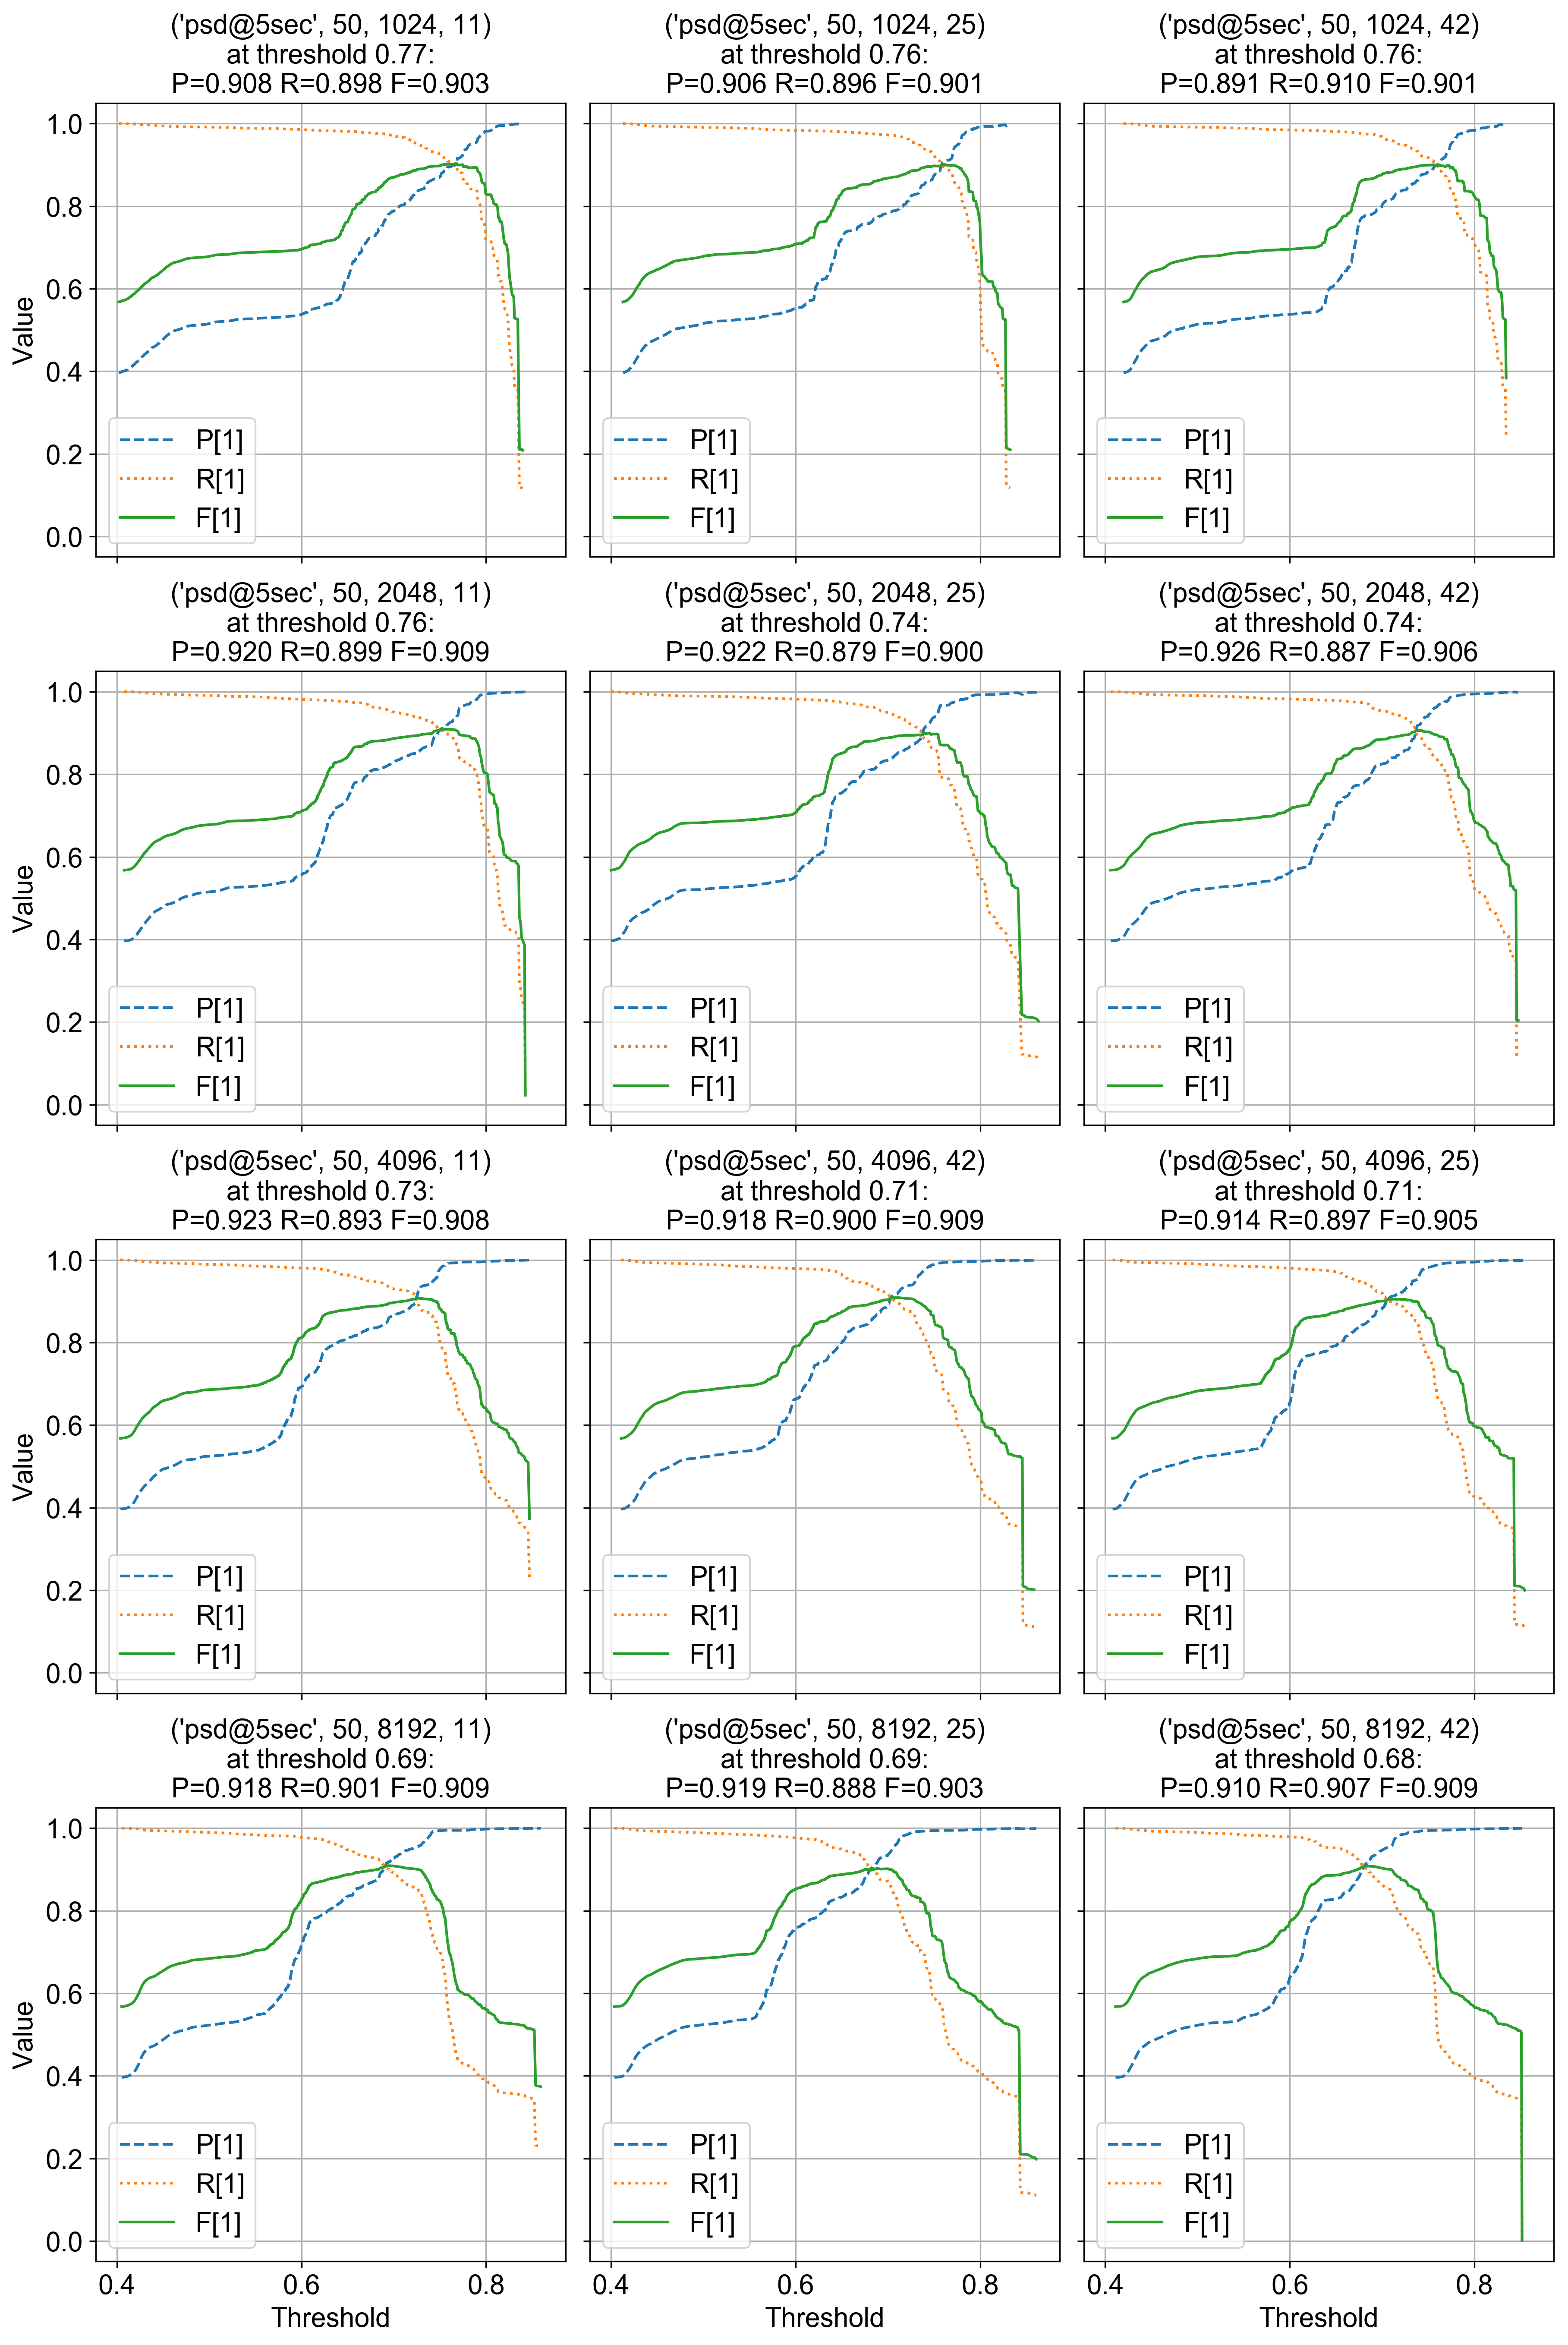

In [62]:
plt.rcParams['figure.figsize'] = (12, 18)
best_pred_df = {k: pred_dfs[k] for k in pred_dfs
                if k.feats=='psd@5sec' and k.max_samples <= 8192 and k.n_estimators == 50}
plot_pre_rec_fscore(best_pred_df, ncols=3,
                    titles=lambda x: str((x.feats, x.n_estimators, x.max_samples, x.random_state)))

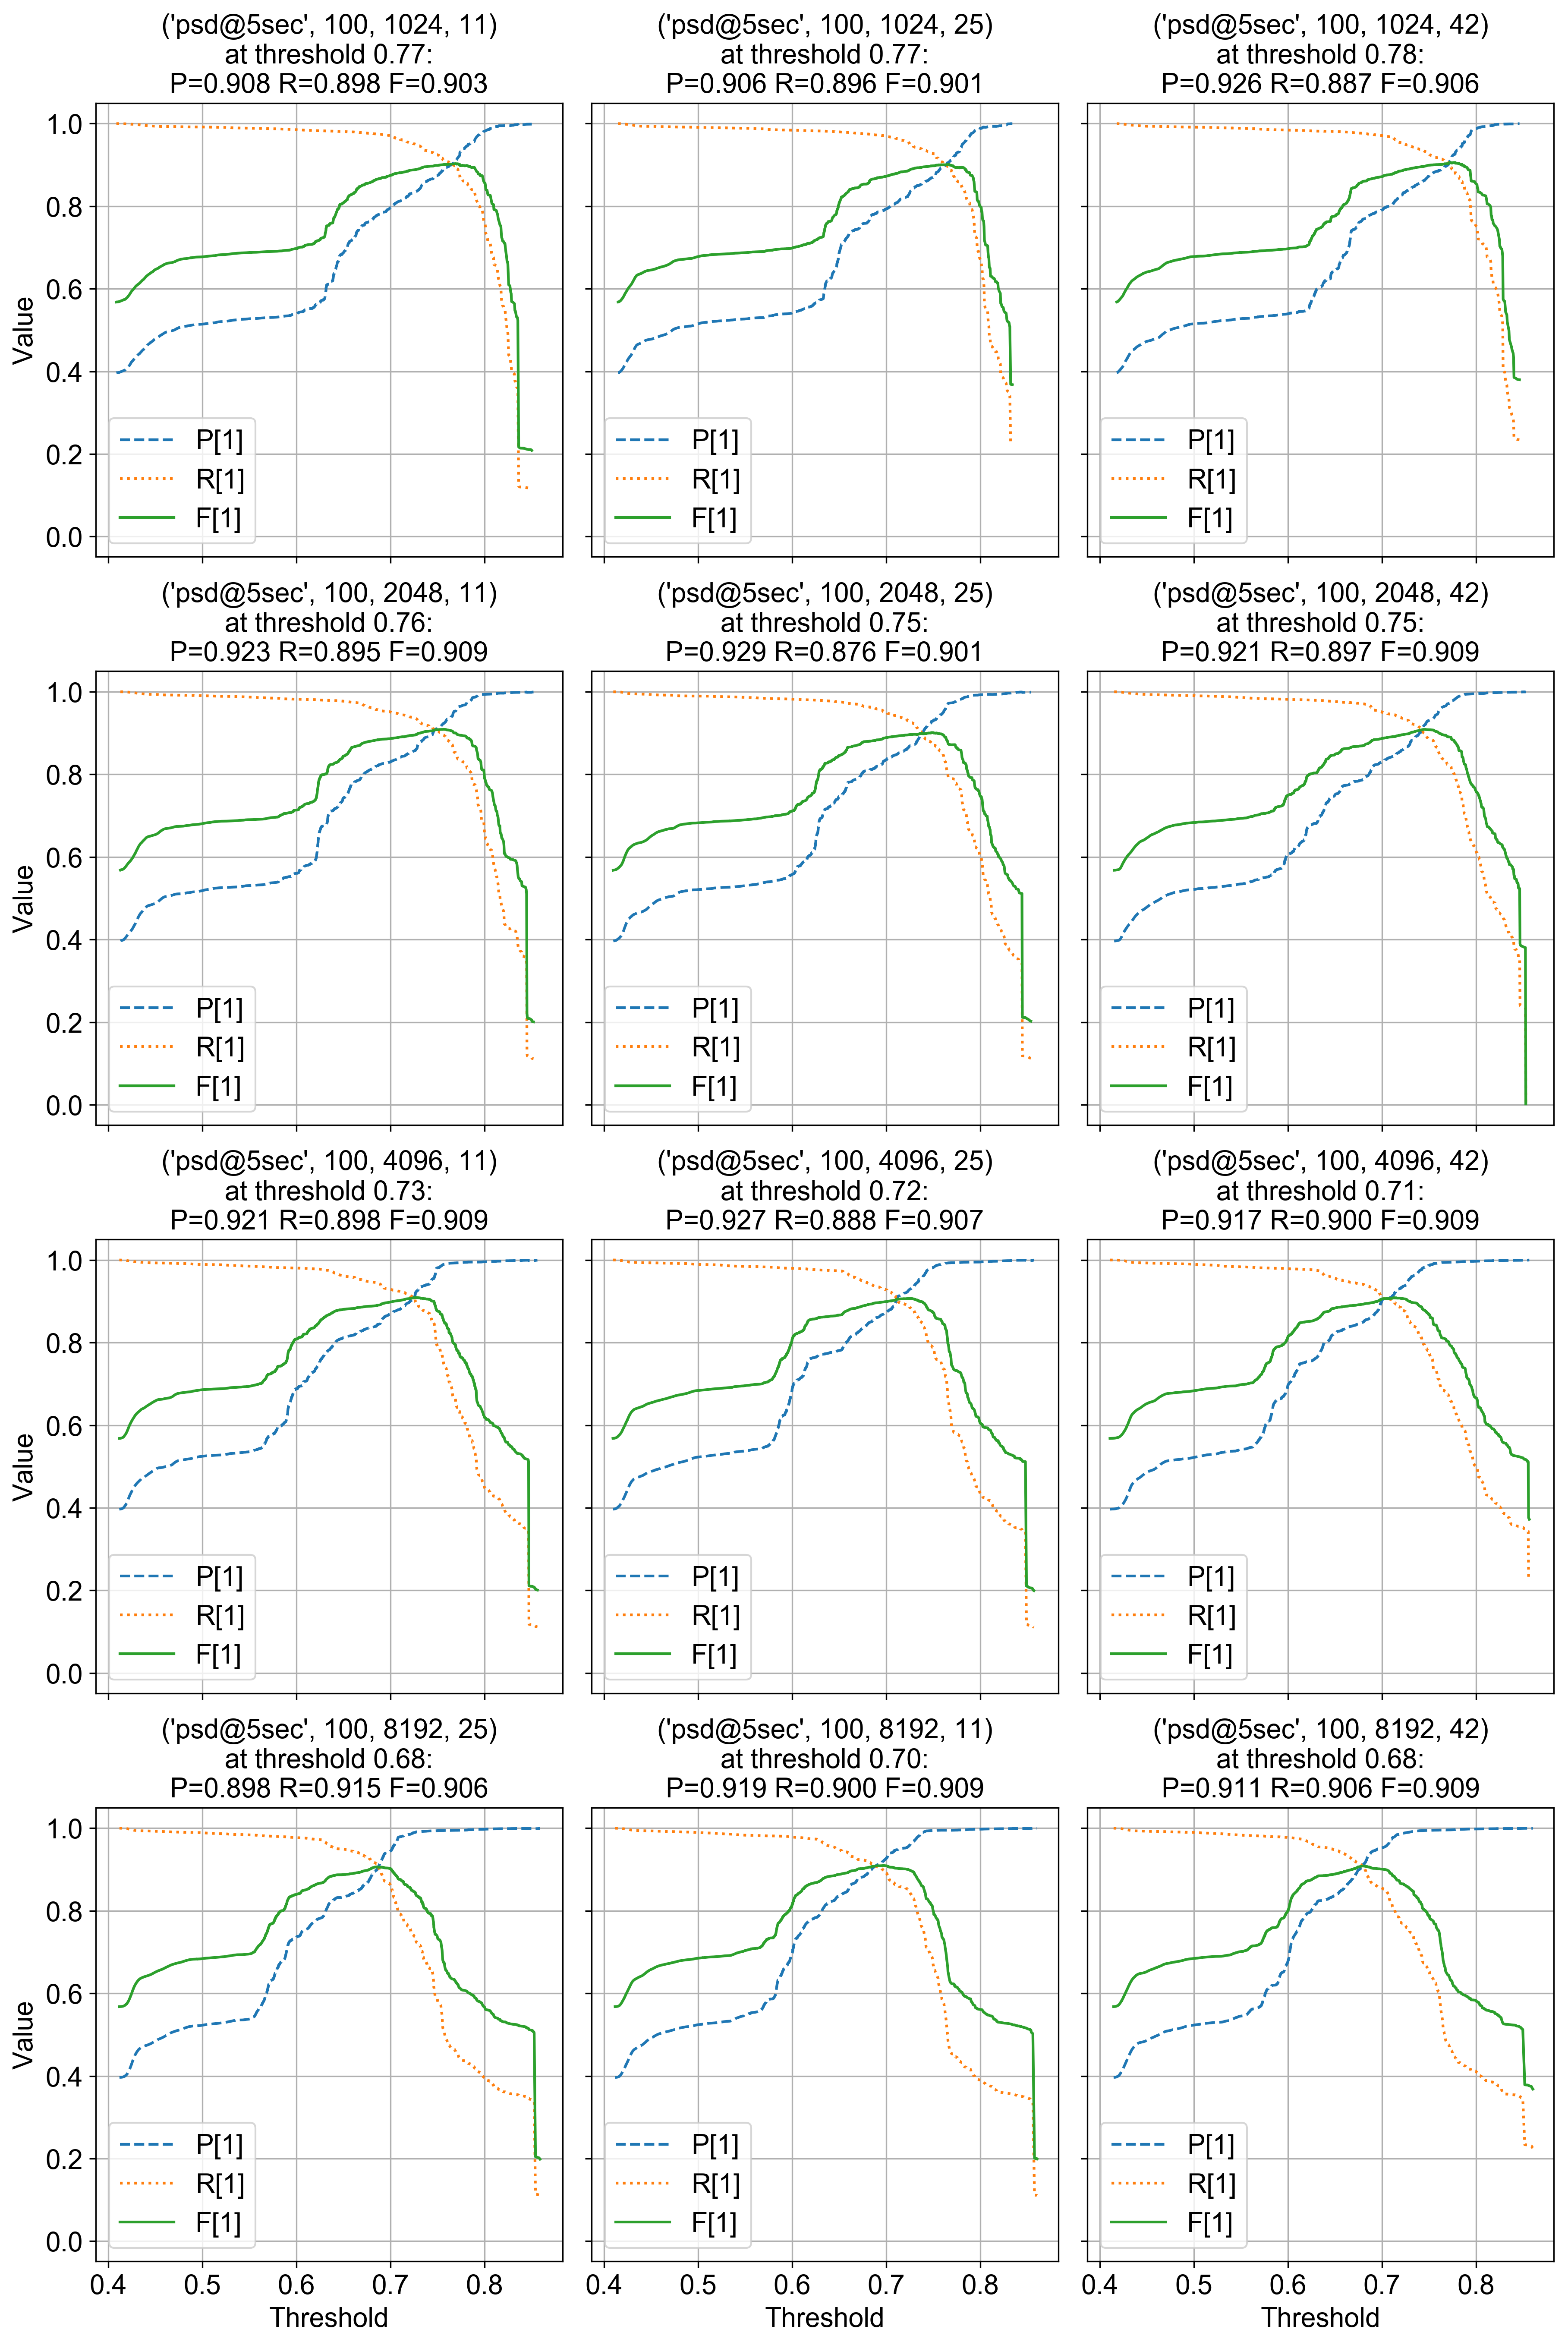

In [63]:
plt.rcParams['figure.figsize'] = (12, 18)
best_pred_df = {k: pred_dfs[k] for k in pred_dfs
                if k.feats=='psd@5sec' and k.max_samples <= 8192 and k.n_estimators == 100}
plot_pre_rec_fscore(best_pred_df, ncols=3,
                    titles=lambda x: str((x.feats, x.n_estimators, x.max_samples, x.random_state)))

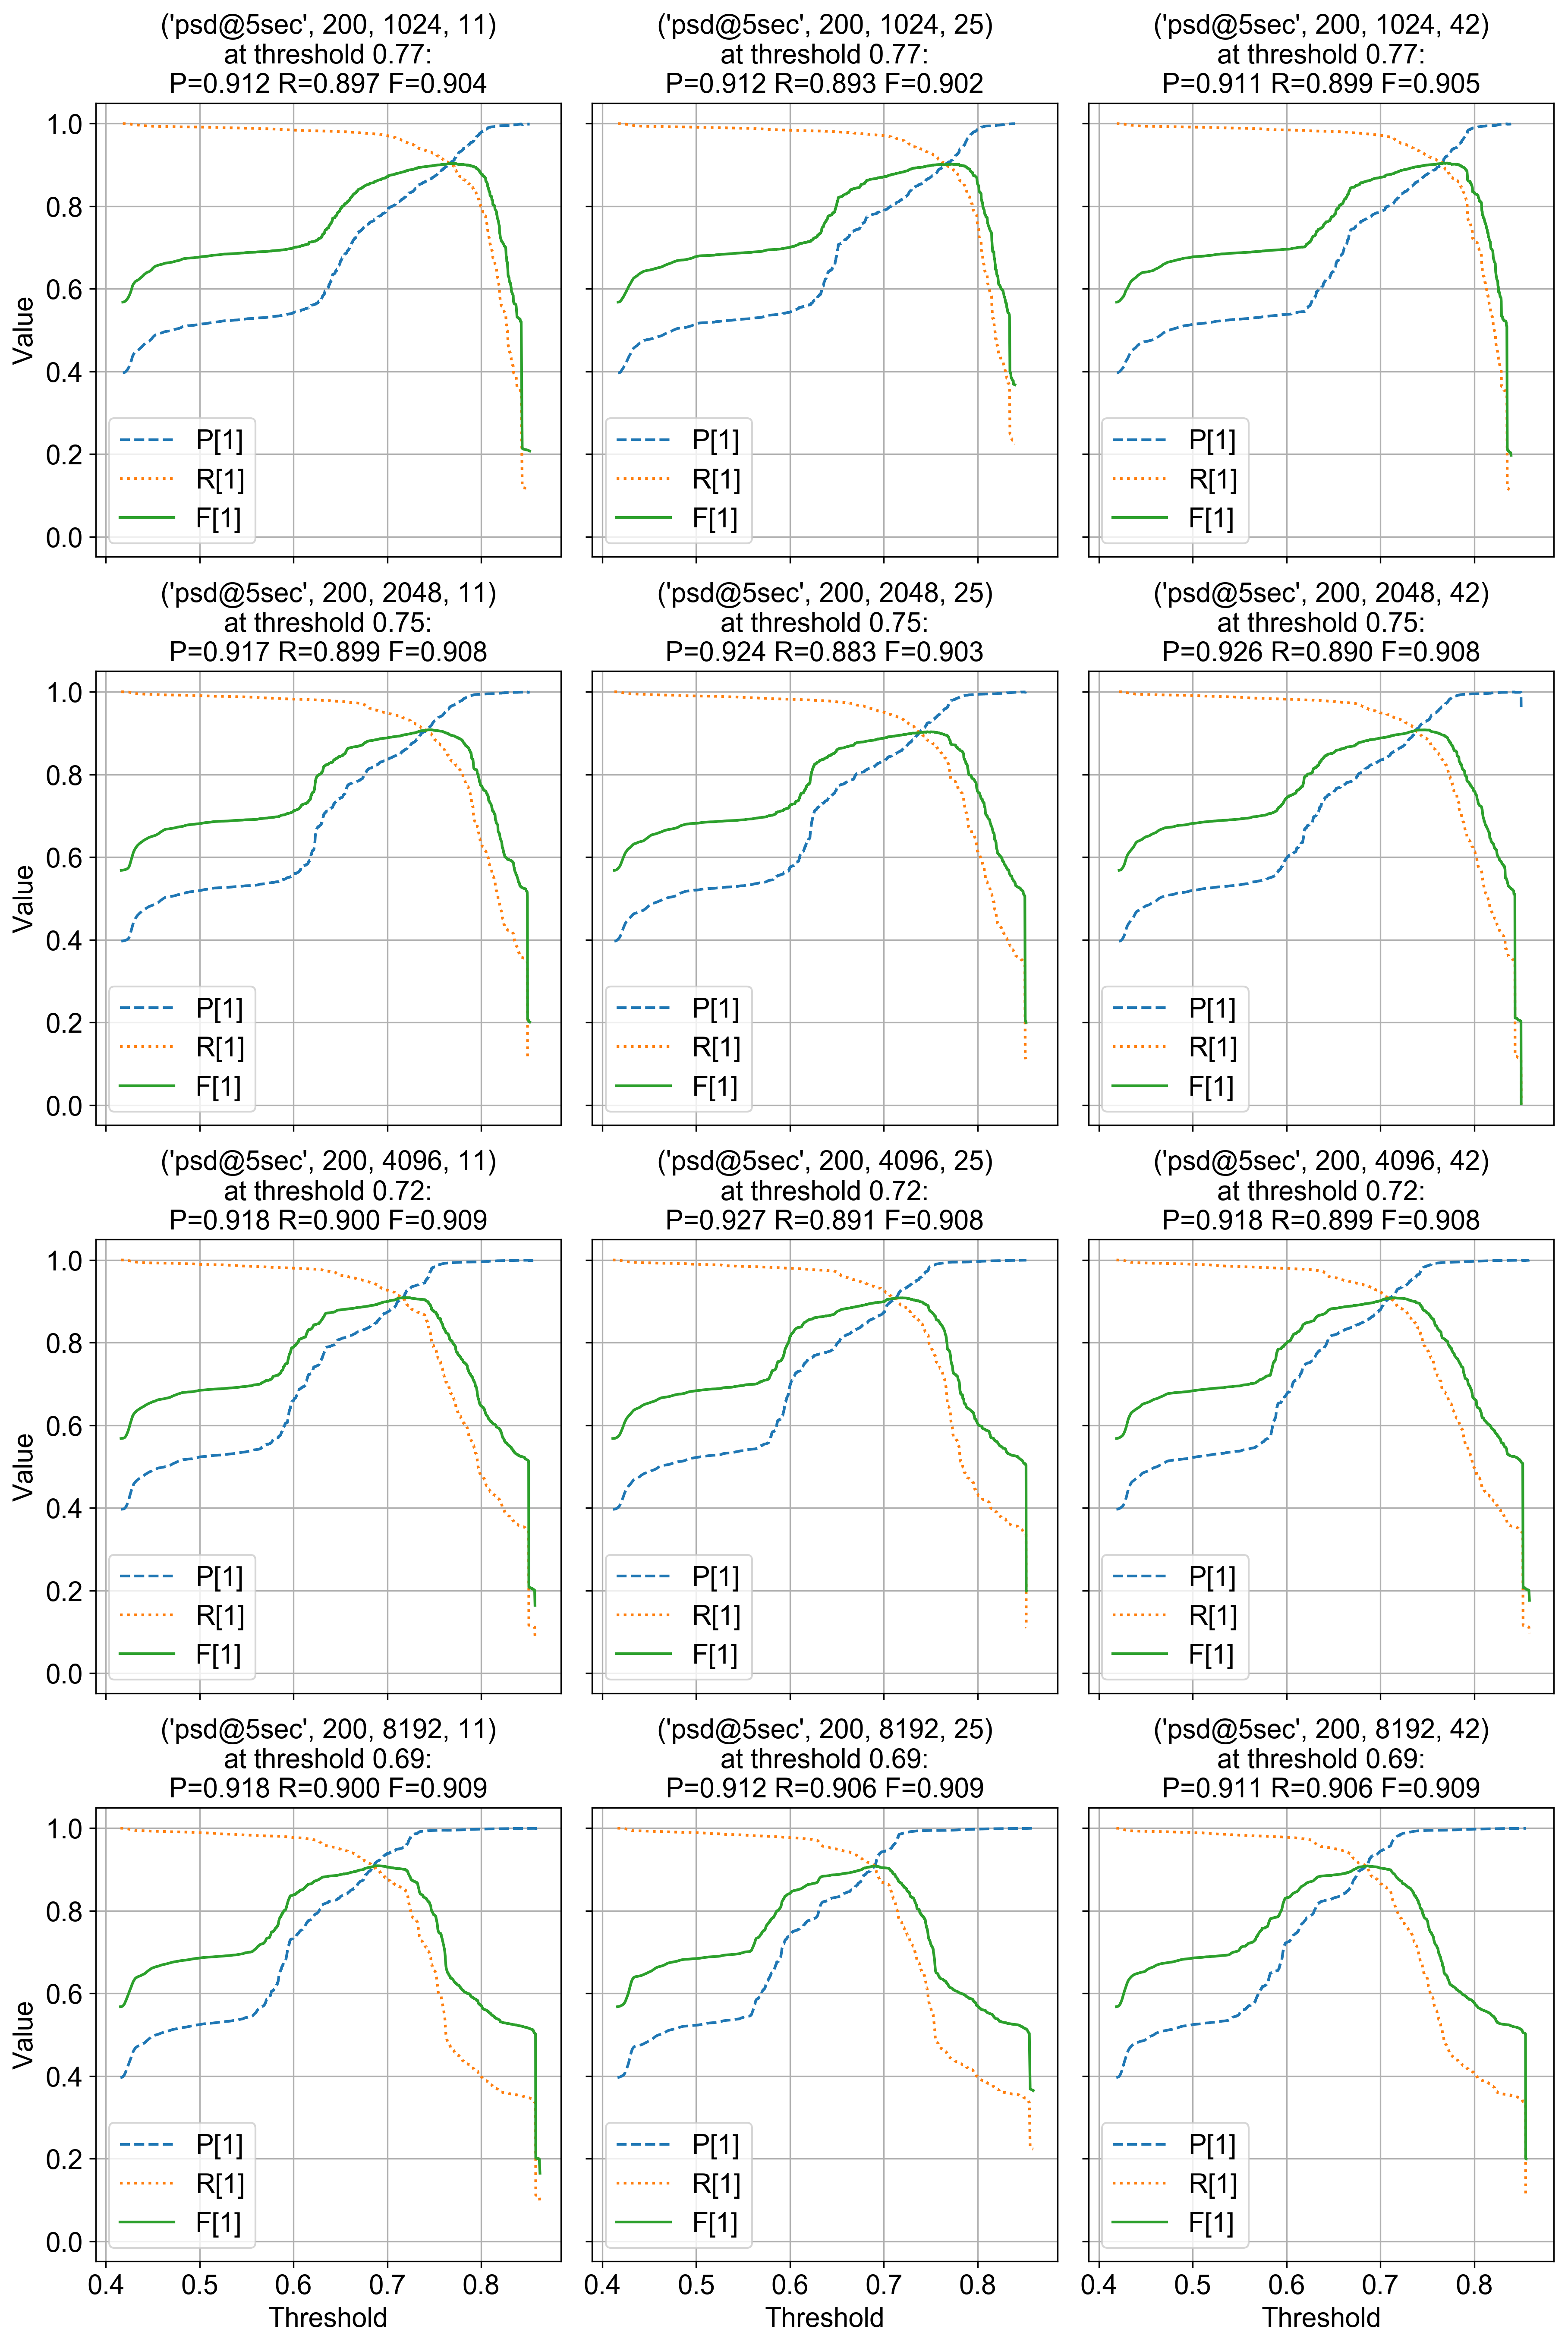

In [64]:
plt.rcParams['figure.figsize'] = (12, 18)
best_pred_df = {k: pred_dfs[k] for k in pred_dfs
                if k.feats=='psd@5sec' and k.max_samples <= 8192 and k.n_estimators == 200}
plot_pre_rec_fscore(best_pred_df, ncols=3,
                    titles=lambda x: str((x.feats, x.n_estimators, x.max_samples, x.random_state)))